# Challenges:
* links
* News
* Encode companies
* Encode people
* Encode cities and countries
* use text data embedding (word/document) or word freq 
* Remove unneeded columns (e.g. images,Deal announced on)
* Imputation
* Twitter link: get followers and latest post?

# Notes on data
* Address col is useless , there's already city,state and country cols
* Crunchbase links are protected with captcha , can't be scraped

imports

In [229]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as pt
import plotly.express as px

Reviewing a sample row from each file

In [205]:
acquired = pd.read_csv("Data/Acquired Tech Companies.csv")
acquired.iloc[0]

Company                                                     Day Software
CrunchBase Profile     http://www.crunchbase.com/organization/day-sof...
Image                  http://a5.images.crunchbase.com/image/upload/c...
Tagline                Day Software develops web applications that al...
Year Founded                                                         NaN
Market Categories                                               Software
Address (HQ)           Barfüsserplatz 6, Basel, Basel-Stadt, Switzerland
City (HQ)                                                          Basel
State / Region (HQ)                                          Basel-Stadt
Country (HQ)                                                 Switzerland
Description            Day was founded in Basel, Switzerland, in 1993...
Homepage                                              http://www.day.com
Twitter                                                              NaN
Acquired by                                        

In [206]:
acquiring = pd.read_csv("Data/Acquiring Tech Companies.csv")
acquiring.iloc[0]

Acquiring Company                                                                        Adobe
CrunchBase Profile                               www.crunchbase.com/organization/adobe-systems
Image                                        http://a2.images.crunchbase.com/image/upload/c...
Tagline                                      Adobe is an American multinational computer so...
Market Categories                            Photo Editing, Design, Creative, Software, Ima...
Year Founded                                                                              1982
IPO                                                                                       1986
Founders                                                         John Warnock, Charles Geschke
Number of Employees                                                                     11,144
Number of Employees (year of last update)                                               2012.0
Total Funding ($)                                 

In [207]:
acquisitions = pd.read_csv("Data/Acquisitions.csv")
acquisitions.iloc[0]

Acquisitions ID                                      EMC acquired Data Domain in 2009
Acquired Company                                                          Data Domain
Acquiring Company                                                                 EMC
Year of acquisition announcement                                                 2009
Deal announced on                                                           8/07/2009
Price                                                                  $2,100,000,000
Status                                                                    Undisclosed
Terms                                                                            Cash
Acquisition Profile                 http://www.crunchbase.com/acquisition/5dc676a1...
News                                                         EMC acquired Data Domain
News Link                           http://www.businesswire.com/news/home/20090708...
Name: 0, dtype: object

In [208]:
founders = pd.read_csv("Data/Founders and Board Members.csv")
founders.iloc[0]

Name                                                 Hans-Werner Hector
CrunchBase Profile      http://de.wikipedia.org/wiki/Hans-Werner_Hector
Role                                                            Founder
Companies                                                           SAP
Image                 http://images.forbes.com/media/lists/10/2006/4...
Name: 0, dtype: object

We will link between the files using these columns:
* Acquisitions ID to link the acquisitions
* 'Founders' and 'Name' to link the Founders

In [209]:
np.intersect1d(acquired.columns, acquisitions.columns).tolist()

['Acquisitions ID']

In [210]:
np.intersect1d(acquiring.columns, acquisitions.columns).tolist()

['Acquiring Company', 'Acquisitions ID']

In [9]:
def ValidateLink(url, timeout=15):
    session = requests.Session()
    # fake headers to make it seem like a real request
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "DNT": "1",
    }
    session.headers.update(headers)
    try:
        response = session.get(url, timeout=timeout, allow_redirects=True, stream=True)
        status_code = response.status_code
        response.close()
        if status_code < 400:
            return True
        else:
            return False
    except Exception as e:
        return False

In [ ]:
def ValidateLinks(urls):
    results = []
    for url in urls:
        results.append(ValidateLink(url))
        if results[-1]:
            return results
    return results

In [ ]:
def ValidateLinksDF(df):
    for col in df.columns:
        for val in df[col]:
            if type(val) == str and ("http" in val):
                print(col)
                results = ValidateLinks(df[col])
                if not pd.Series(results).any():
                    print(f'Column "{col}" had no valid links , or is using captcha.')
                    print("Try it yourself:")
                    print(df[col][0] + "\n")
                break

In [12]:
ValidateLinksDF(acquired)

CrunchBase Profile
Column "CrunchBase Profile" had no valid links , or is using captcha.
Try it yourself:
http://www.crunchbase.com/organization/day-software

Image
Column "Image" had no valid links , or is using captcha.
Try it yourself:
http://a5.images.crunchbase.com/image/upload/c_pad,h_500,w_500/v1397187256/0ef62e4243274cafe1a563dda2bca363.png

Homepage
Twitter
API


* CrunchBase is using CAPTCHA , so we won't drop it now but we will proccess it later
* Image links are all corrupt so we will drop the column 

In [213]:
acquired = acquired.drop("Image", axis=1)

In [13]:
ValidateLinksDF(acquiring)

Image
Column "Image" had no valid links , or is using captcha.
Try it yourself:
http://a2.images.crunchbase.com/image/upload/c_pad,h_500,w_500/v1397180657/2cd912e176145af3618549d60b7959a1.png

Homepage
Twitter
API


* drop Image also

In [214]:
acquiring = acquiring.drop("Image", axis=1)

In [14]:
ValidateLinksDF(acquisitions)

Acquisition Profile
Column "Acquisition Profile" had no valid links , or is using captcha.
Try it yourself:
http://www.crunchbase.com/acquisition/5dc676a13d41c2ee87169ce59476ec2d

News Link


* acquisitions profile is also a crunchbase link

In [15]:
ValidateLinksDF(founders)

CrunchBase Profile
Image


We don't need the exact address of the company, we already have the city , state and country

In [215]:
acquired=acquired.drop('Address (HQ)', axis=1)
acquiring=acquiring.drop('Address (HQ)', axis=1)

Dropping 'year of last update' of the number of employees , because we don't need it directly and can't use it in any way to pridct the current number

In [216]:
acquiring=acquiring.drop('Number of Employees (year of last update)', axis=1)

In [217]:
acquiring.iloc[12]['Tagline']

'EMC manufactures information management and storage software systems.'

In [59]:
for l in acquiring.iloc[12]['Description'].split('.'):
    print(l +'\n') 

EMC is a global leader in enabling businesses and service providers to transform their operations and deliver information technology as a service ITaaS

 Fundamental to this transformation is cloud computing

 Through innovative products and services, EMC accelerates the journey to cloud computing, helping IT departments to store, manage, protect and analyze their most valuable asset — information — in a more agile, trusted and cost-efficient way

EMC is a manufacturer of software and systems for information management and storage

  EMC produces a range of enterprise storage products, including hardware disk arrays and storage management software

 Its flagship product, the Symmetrix, is the foundation of storage networks in many large data centers





* 'Tagline' contains a brief and precise description of the company , while the 'Description' is very long and doesn't provide any more important details, 
so we will drop the 'Description'

In [218]:
acquiring=acquiring.drop('Description', axis=1)
acquired=acquired.drop('Description', axis=1)

**Adding the target variable**

In [219]:
acquisitions['Price']=[int(price.removeprefix('$').replace(',','')) for price in acquisitions['Price']]

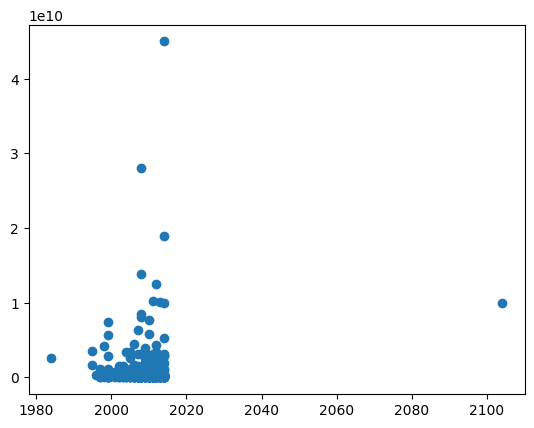

In [221]:
pt.scatter(acquisitions['Year of acquisition announcement'],acquisitions['Price'])

There was a wrongly entered value, so I looked at the link and corrected it

In [222]:
acquisitions.loc[acquisitions['Year of acquisition announcement']==2104,'Year of acquisition announcement']=2014 

In [220]:
acquired['Price']=None
acquired['Year of acquisition announcement']=None

In [223]:
for i,company in enumerate(acquisitions['Acquired Company']):
    acquired.loc[acquired['Company']==company,'Price']=acquisitions.iloc[i]['Price']
    acquired.loc[acquired['Company']==company,'Year of acquisition announcement']=acquisitions.iloc[i]['Year of acquisition announcement']

update the datatypes automatically

In [224]:
acquired=acquired.infer_objects()
acquisitions=acquisitions.infer_objects()

In [225]:
acquired.describe()

,Year Founded,Price,Year of acquisition announcement
count,241.000000,3.100000e+02,310.000000
mean,2000.526971,1.067965e+09,2008.961290
std,14.027365,3.529433e+09,4.238648
min,1840.000000,1.400000e+06,1995.000000
25%,1998.000000,6.500000e+07,2007.000000
50%,2003.000000,1.780000e+08,2010.000000
75%,2007.000000,5.787500e+08,2012.000000
max,2014.000000,4.500000e+10,2014.000000


The specific date which the deal was announced on doesn't matter , what matters is the year so the model can know that inflation affects the price

In [226]:
acquisitions=acquisitions.drop('Deal announced on',axis=1)

Plotting again without the error, now we can see that the overall trend of prices tends to go up, that's why we added the 'Year of acquisitions announcement' column

In [232]:
acquired.iloc[0]

Company                                                                  Day Software
CrunchBase Profile                  http://www.crunchbase.com/organization/day-sof...
Tagline                             Day Software develops web applications that al...
Year Founded                                                                      NaN
Market Categories                                                            Software
City (HQ)                                                                       Basel
State / Region (HQ)                                                       Basel-Stadt
Country (HQ)                                                              Switzerland
Homepage                                                           http://www.day.com
Twitter                                                                           NaN
Acquired by                                                                     Adobe
Acquisitions ID                           Adobe System

In [233]:
fig = px.scatter(
    acquired,
    x='Year Founded',
    y='Price',
    title='Acquisition Price by Year'
)
fig.show()

Another error found and corrected

In [ ]:
acquired.loc[acquired['Year Founded']==1840,'Year Founded']=2006
acquired.loc[acquired['Year Founded']==1933,'Year Founded']=1989

In [252]:
fig = px.scatter(
    acquired,
    x='Year Founded',
    y='Price',
    title='Acquisition Price by Year'
)
fig.show()

In [253]:
fig = px.scatter(
    acquired,
    x='Year of acquisition announcement',
    y='Price',
    title='Acquisition Price by Year'
)
fig.show()